<a href="https://colab.research.google.com/drive/1kW01AIvH0A92o5TnYrSWNmK0qBFazjwf#scrollTo=06fQFLOVhMZD" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Facial Identifier

## Scenario:
Employee identifer by Facial Recognition

## Dataset:
https://www.kaggle.com/datasets/kasikrit/att-database-of-faces/

In [1]:
import os
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from PIL import Image
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import random

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Dataset: https://www.kaggle.com/datasets/kasikrit/att-database-of-faces/

!unzip 'drive/MyDrive/Data/ORL_faces.zip'

Archive:  drive/MyDrive/Data/ORL_faces.zip
   creating: ORL_faces/
  inflating: __MACOSX/._ORL_faces    
   creating: ORL_faces/s34/
  inflating: __MACOSX/ORL_faces/._s34  
   creating: ORL_faces/s33/
  inflating: __MACOSX/ORL_faces/._s33  
   creating: ORL_faces/s5/
  inflating: __MACOSX/ORL_faces/._s5  
   creating: ORL_faces/s2/
  inflating: __MACOSX/ORL_faces/._s2  
   creating: ORL_faces/s32/
  inflating: __MACOSX/ORL_faces/._s32  
   creating: ORL_faces/s35/
  inflating: __MACOSX/ORL_faces/._s35  
   creating: ORL_faces/s3/
  inflating: __MACOSX/ORL_faces/._s3  
   creating: ORL_faces/s4/
  inflating: __MACOSX/ORL_faces/._s4  
  inflating: ORL_faces/.DS_Store     
  inflating: __MACOSX/ORL_faces/._.DS_Store  
   creating: ORL_faces/s26/
  inflating: __MACOSX/ORL_faces/._s26  
   creating: ORL_faces/s19/
  inflating: __MACOSX/ORL_faces/._s19  
   creating: ORL_faces/s21/
  inflating: __MACOSX/ORL_faces/._s21  
   creating: ORL_faces/s17/
  inflating: __MACOSX/ORL_faces/._s17  
   

In [4]:
data_path = 'ORL_faces'  # On Kaggle, this would be '/kaggle/input/att-database-of-faces'
work_path = 'ORL_faces'  # On Kaggle, this would be '/kaggle/working'

In [5]:
def load_images(src_folder: str, work_folder: str, sub_folder_prefix: str, file_extension: str) -> pd.DataFrame:
    images = []
    labels = []
    if not os.path.exists(work_folder):
        os.makedirs(work_folder)
    for lbl in [int(lbl[1:]) for lbl in os.listdir(src_folder) if lbl.startswith(sub_folder_prefix)]:
        lbl_dir = f'{src_folder}/{sub_folder_prefix}{lbl}'
        if not os.path.exists(lbl_dir.replace(src_folder, work_folder)):
            os.makedirs(lbl_dir.replace(src_folder, work_folder))
        for img in [img for img in os.listdir(lbl_dir) if img.endswith(file_extension)]:
            img_path = f'{lbl_dir}/{img}'
            img = Image.open(img_path)
            new_path = img_path.replace(file_extension, '.png').replace(src_folder, work_folder)
            img.save(new_path)
            images.append(new_path)
            labels.append(f'{lbl:02d}')
    return pd.DataFrame({'image': images, 'label': labels})

In [6]:
# Load the images
df = load_images(data_path, work_path, 's', '.pgm')

# Summarize the images
img_arr = np.array([Image.open(img) for img in df['image']])
print('Image shape(s) and corresponding count(s):')
print(pd.Series([i.shape for i in img_arr]).value_counts().to_string(index=True))
print('\nMin/Max pixel value(s) over all images:')
print(f'{img_arr.min()}, {img_arr.max()}')
print('\nCounts of images for each label:')
print(pd.Series(df["label"].value_counts()).sort_index().to_frame().T.to_string(index=True))

Image shape(s) and corresponding count(s):
(112, 92)    400

Min/Max pixel value(s) over all images:
0, 251

Counts of images for each label:
label  01  02  03  04  05  06  07  08  09  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40
count  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10  10


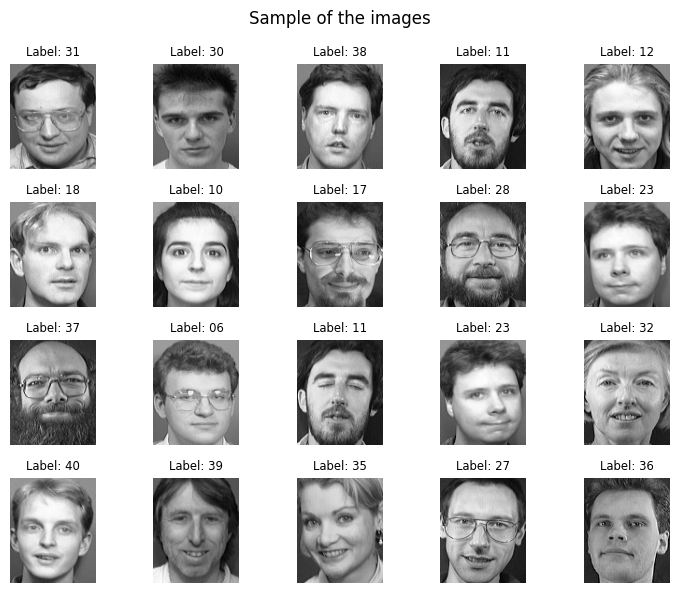

In [7]:
def display_images(df: pd.DataFrame, pct: int, title: str) -> None:
    num_images = math.ceil(len(df) * pct / 100.0)
    img_per_row = math.ceil(math.sqrt(num_images))
    rows = math.ceil(num_images / img_per_row)
    plt.figure(figsize=(img_per_row*1.5, rows*1.5))
    plt.suptitle(title)
    picked_image_indexes = []
    for i in range(num_images):
        idx = None
        while (idx is None or idx in picked_image_indexes):
            idx = np.random.randint(0, df.shape[0])
        picked_image_indexes.append(idx)
    for i in range(img_per_row * rows):
        plt.subplot(rows, img_per_row, i+1)
        plt.imshow(Image.open(df['image'].iloc[picked_image_indexes[i]]), cmap='gray')
        plt.title(f"Label: {df['label'].iloc[picked_image_indexes[i]]}", fontsize='small')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display a sample of the images
display_images(df, 5, 'Sample of the images')

In [8]:
def train_val_test_split(df: pd.DataFrame, test_size: float, val_size: float, random_state: int=42) -> tuple:
    true_val_size = val_size / (1 - test_size)
    X_train, X_test, y_train, y_test = train_test_split(df['image'], df['label'], test_size=test_size, random_state=random_state, stratify=df['label'])
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=true_val_size, random_state=random_state, stratify=y_train)
    return pd.DataFrame({'image': X_train, 'label': y_train}), pd.DataFrame({'image': X_val, 'label': y_val}), pd.DataFrame({'image':X_test, 'label': y_test})

In [9]:
df_train, df_val, df_test = train_val_test_split(df, test_size=0.2, val_size=0.2)

# Show the size of each set
print(f'Training set size: {len(df_train)}')
print(f'Validation set size: {len(df_val)}')
print(f'Testing set size: {len(df_test)}')

Training set size: 240
Validation set size: 80
Testing set size: 80


In [10]:
# Define image transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Ensure images are grayscale
    transforms.Resize((64, 64)),  # Resize images to a consistent size
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
    transforms.RandomRotation(10),  # Randomly rotate images
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize pixel values
])

def transform_image(image_path):
    image = Image.open(image_path)
    image_tensor = transform(image)
    return image_tensor

# Example usage with your DataFrame:
df_train['image_tensor'] = df_train['image'].apply(transform_image)
df_val['image_tensor'] = df_val['image'].apply(transform_image)
df_test['image_tensor'] = df_test['image'].apply(transform_image)

# Display first image tensor shape
first_image_tensor = df_train['image_tensor'].iloc[0]
print(first_image_tensor.shape)

torch.Size([1, 64, 64])


In [11]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=40):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 32 * 32, num_classes) # Adjust input features based on image size and convolutions

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 32 * 32 * 32)  # Adjust input features based on image size and convolutions
        x = self.fc1(x)
        return x

class ImprovedCNNModel(nn.Module):
    def __init__(self, num_classes=40):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25) # Added dropout for regularization
        self.fc1 = nn.Linear(128 * 16 * 16, 512) # Adjusted input features
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x) # Apply dropout
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Apply dropout
        x = self.fc2(x)
        return x

#model = CNNModel()
model = ImprovedCNNModel()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-4) # AdamW with weight decay


In [12]:
# Train the model using the prepared data. Plot the results to evaluate the model's performance.

num_epochs = 10
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    for index in range(len(df_train)):
      images = df_train['image_tensor'].iloc[index].unsqueeze(0)
      labels = torch.tensor([int(df_train['label'].iloc[index]) -1])
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
    train_loss = running_loss / len(df_train)
    train_losses.append(train_loss)

    # Validation loop
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
      for index in range(len(df_val)):
        images = df_val['image_tensor'].iloc[index].unsqueeze(0)
        labels = torch.tensor([int(df_val['label'].iloc[index])-1])
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
    val_loss = running_loss / len(df_val)
    val_losses.append(val_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

Epoch [1/10], Train Loss: 3.6902, Val Loss: 3.5114
Epoch [2/10], Train Loss: 3.1318, Val Loss: 2.5755
Epoch [3/10], Train Loss: 1.8707, Val Loss: 1.8915
Epoch [4/10], Train Loss: 1.0420, Val Loss: 1.2509
Epoch [5/10], Train Loss: 0.5059, Val Loss: 0.9660
Epoch [6/10], Train Loss: 0.2294, Val Loss: 0.9804
Epoch [7/10], Train Loss: 0.2300, Val Loss: 0.9367
Epoch [8/10], Train Loss: 0.1677, Val Loss: 0.8939
Epoch [9/10], Train Loss: 0.1561, Val Loss: 0.7027
Epoch [10/10], Train Loss: 0.0694, Val Loss: 0.6702


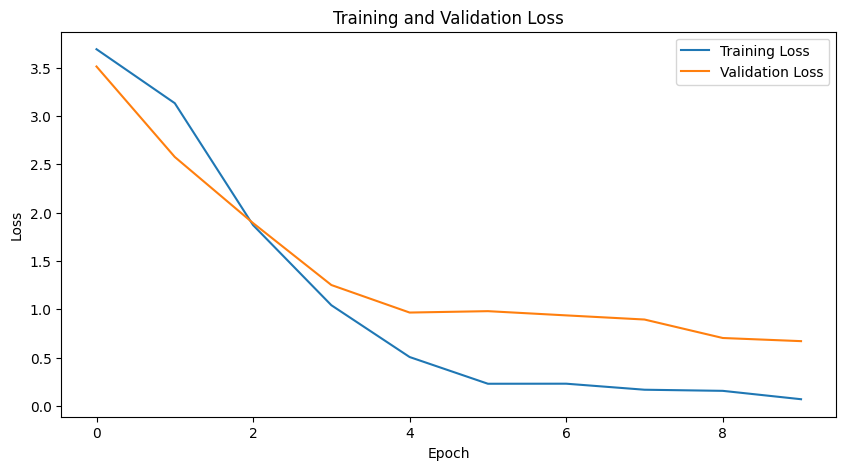

In [13]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [14]:
# Evaluate accuracy, precision, recall and f1 score of the model

y_true = []
y_pred = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for index in range(len(df_test)):
        image_tensor = df_test['image_tensor'].iloc[index].unsqueeze(0)
        true_label = int(df_test['label'].iloc[index]) - 1  # Assuming labels are 1-indexed
        y_true.append(true_label)

        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        y_pred.append(predicted.item())

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted') # Use weighted average for multi-class
recall = recall_score(y_true, y_pred, average='weighted') # Use weighted average for multi-class
f1 = f1_score(y_true, y_pred, average='weighted') # Use weighted average for multi-class

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.8625
Precision: 0.8662
Recall: 0.8625
F1 Score: 0.8493


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


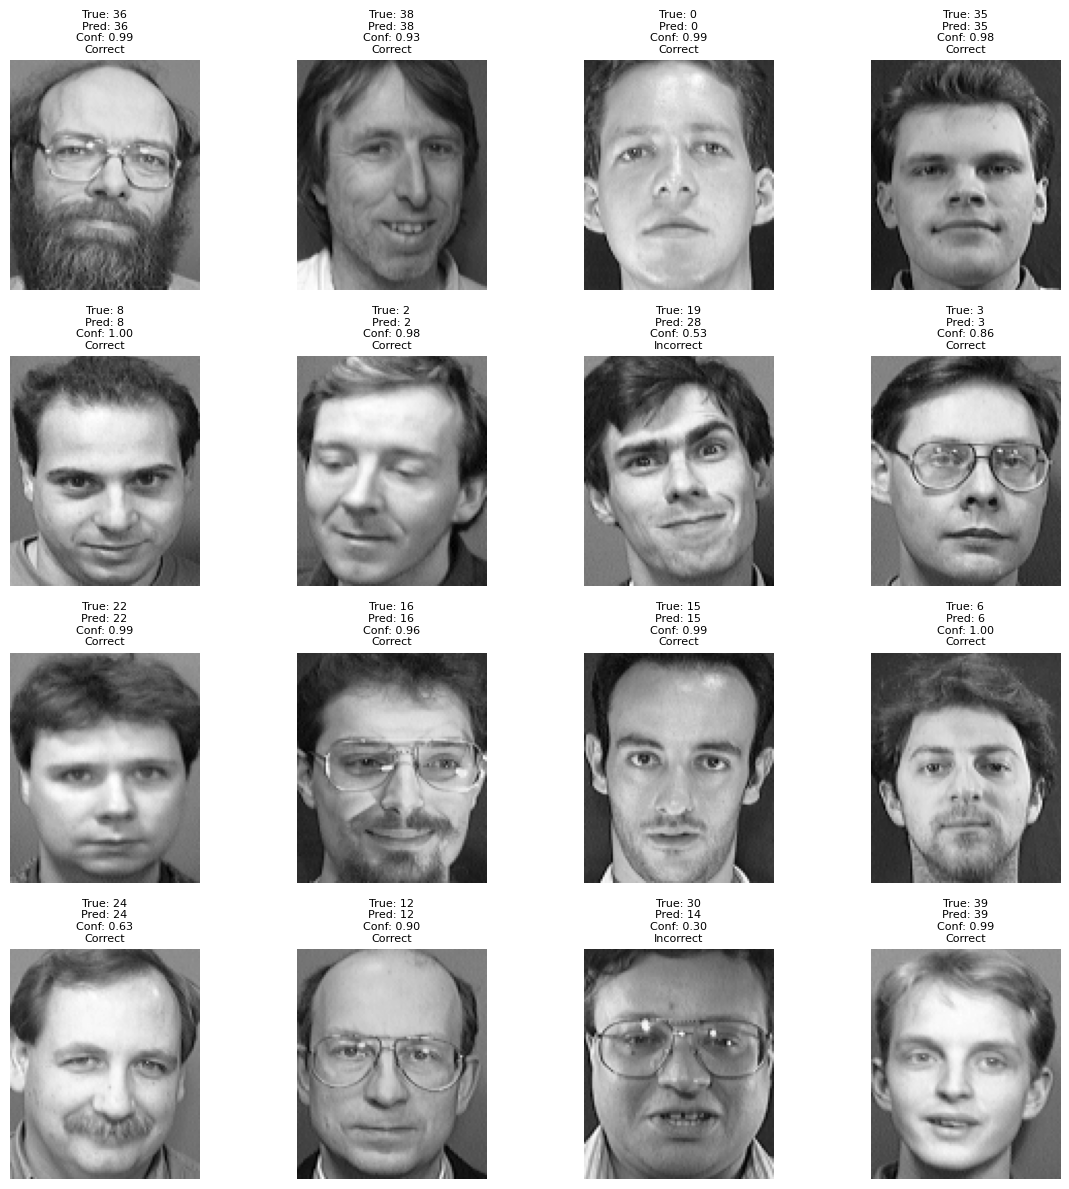

In [15]:
# Pick 16 random images and evaluate. show the image, true label, predicted label and confidence, and display 4 x 4

import matplotlib.pyplot as plt
import random

# Assuming df_test, model, and other necessary variables are defined as in your provided code

def display_random_images(df_test, model, num_images=16):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    random_indices = random.sample(range(len(df_test)), num_images)

    model.eval()
    with torch.no_grad():
        for i, index in enumerate(random_indices):
            row = i // 4
            col = i % 4
            image_tensor = df_test['image_tensor'].iloc[index].unsqueeze(0)
            true_label = int(df_test['label'].iloc[index]) - 1

            outputs = model(image_tensor)
            _, predicted_label = torch.max(outputs, 1)
            confidence = torch.softmax(outputs, dim=1)[0][predicted_label[0]].item() # Get confidence score

            label = 'Correct' if predicted_label[0] == true_label else 'Incorrect'
            image = Image.open(df_test['image'].iloc[index])
            axes[row, col].imshow(image, cmap='gray')
            axes[row, col].set_title(f"True: {true_label}\nPred: {predicted_label[0]}\nConf: {confidence:.2f}\n{label}", fontsize=8)
            axes[row, col].axis('off')
    plt.tight_layout()
    plt.show()

display_random_images(df_test, model)


# Save the model

In [16]:
import torch

# Save the model's state dictionary
torch.save(model.state_dict(), '/content/drive/MyDrive/CV_Proj2_weights.pth')

# to load the model later:
# model = ImprovedCNNModel() # or your CNNModel
# model.load_state_dict(torch.load('/content/drive/MyDrive/CV_Proj2_weights.pth'))
# model.eval() # Important: set to evaluation mode

# Deploy and test using Streamlit

In [1]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 133.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.8 MB/s eta 0:00:00


In [25]:
%%writefile app.py

import streamlit as st
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

# Load the model
class ImprovedCNNModel(torch.nn.Module): # Replace with your actual model architecture
    def __init__(self, num_classes=40):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.25) # Added dropout for regularization
        self.fc1 = nn.Linear(128 * 16 * 16, 512) # Adjusted input features
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x) # Apply dropout
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Apply dropout
        x = self.fc2(x)
        return x

model = ImprovedCNNModel()
model.load_state_dict(torch.load('/content/drive/MyDrive/CV_Proj2_weights.pth')) # Replace this with appropriate path
model.eval()

# Define image transformations (Must be the same as training)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

st.title("Facial Identifier")
st.header("Scenario: Employee identifer by Facial Recognition.", divider=True)
st.subheader("Dataset: ttps://www.kaggle.com/datasets/kasikrit/att-database-of-faces/", divider=True)
st.subheader("Upload an image and get the prediction.")

uploaded_file = st.file_uploader("Choose an image...", type=["pgm"])

if uploaded_file is not None:
    image = Image.open(uploaded_file)
    st.image(image, caption="Uploaded Image", use_container_width=True)

    # Preprocess the image
    image_tensor = transform(image).unsqueeze(0)

    # Make a prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.softmax(outputs, dim=1)[0][predicted[0]].item()

    st.write(f"Prediction: {predicted.item() + 1}") # Labels are 1-indexed
    st.write(f"Confidence: {confidence:.2f}")

Overwriting app.py


# Deploy app.py and the saved model.

## Below is a hack to run Streamlit from Colab

In [3]:
!npm install localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼
added 22 packages in 3s
⠴
⠴3 packages are looking for funding
⠴  run `npm fund` for details
⠴

In [4]:
import urllib
print("Password/Enpoint IP for localtunnel is:",urllib.request.urlopen('https://ipv4.icanhazip.com').read().decode('utf8').strip("\n"))

Password/Enpoint IP for localtunnel is: 35.236.169.211


In [26]:
# run streamlit in colab

!streamlit run app.py &>/content/logs.txt & npx localtunnel --port 8501


⠙your url is: https://vast-moles-repair.loca.lt
^C
